In [361]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [304]:
dataset = pd.read_csv('../db/AmesHousing.csv', sep='\t')
localCopy=dataset.copy(deep=True)

In [305]:
#SEPARATION OF CATEGORICAL AND NUMERICAL FEATURES

#AmesExplanations.txt indicates a separation of the data in 4 types:
# Continuous - numerical
# Nominal - categorical
# Ordinal - usually categorical, numerical if order matters
# Discrete - usually numerical, categorical if it's an ID

cat_features = ['MS SubClass','MS Zoning','Street','Alley',
                'Lot Shape','Land Contour','Utilities','Lot Config',
                'Land Slope','Neighborhood','Condition 1','Condition 2',
                'Bldg Type','House Style','Roof Style','Roof Matl',
                'Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation',
                'Heating','Central Air','Electrical','Garage Type',
                'Paved Drive','Misc Feature','Sale Condition']

num_features = ['Lot Frontage','Lot Area','Overall Qual','Overall Cond',
                'Year Built','Year Remod/Add','Mas Vnr Area','Exter Qual',
                'Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure',
                'BsmtFin Type 1', 'BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2',
                'Bsmt Unf SF','Total Bsmt SF','Heating QC','1st Flr SF','2nd Flr SF',
                'Low Qual Fin SF','Gr Liv Area','Bsmt Full Bath','Bsmt Half Bath',
                'Full Bath','Half Bath','Bedroom','Kitchen','Kitchen Qual','TotRmsAbvGrd',
                'Functional','Fireplaces','Fireplace Qu',
                'Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual',
                'Garage Cond','Wood Deck SF','Open Porch SF','Enclosed Porch','3-Ssn Porch',
                'Screen Porch','Pool Area','Pool QC','Fence','Misc Val','Mo Sold','Yr Sold',
                'Sale Type','SalePrice']


# Features that describe a grade (ex. Quality: 1-10 or Poor/Average/Excellent) will be treated as
# numeric values. There are string values as well; these will be mapped to numbers so that the model
# understands them

# to be mapped to numbers: Exter Qual, Exter Cond, Bsmt Qual, Bsmt Cond, Bsmt Exposure,
# BsmtFin Type 1, BsmtFinType 2, HeatingQC, KitchenQual, Functional, FireplaceQu, 
# Garage Finish, Garage Qual, Garage Cond, Pool QC, Fence, Sale Type

ordinal_maps = {'Exter Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Exter Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Exposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
                'BsmtFin Type 1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'BsmtFin Type 2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'Heating QC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Kitchen Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
                'Fireplace Qu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Finish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
                'Garage Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Pool QC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
                'Fence': {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4},
                'Sale Type': {'Oth':1, 'ConLD':2, 'ConLI':3, 'ConLw':4, 'Con':5, 'COD':6, 'New':7, 'VWD':8, 'CWD':9, 'WD':10}
                }

# apply the mappings to the strings
for col,mapping in ordinal_maps.items():
    if col in localCopy.columns:
        localCopy[col] = localCopy[col].map(mapping)

In [306]:
#FEATURE ENGINEERING: Deletion

#dropping the PID , Order Column
# Yr Sold, Sale Price, Year Built, Total Bsmt SF, Gr Liv Area because they have a high correlation with 
# other features, we are gonna keep them and delete the others
localCopy.drop(columns=['PID','Order','Overall Qual', 'Garage Yr Blt', '1st Flr SF','TotRms AbvGrd', 'Garage Cars'],inplace=True)
localCopy.drop(index=[1341,1497,1577,2236],inplace=True)

#dropping columns with many null values
for column in localCopy:
    if localCopy[column].isna().sum()>2000:
        localCopy.drop(column, axis=1, inplace=True)

#After all deletions, remove the deleted features in the 2 cat/num separation arrays as well
cat_features = [col for col in cat_features if col in localCopy.columns]
num_features = [col for col in num_features if col in localCopy.columns]
#Also do the same for the ordinal_maps
ordinal_maps = {col: mapping for col,mapping in ordinal_maps.items() if col in localCopy.columns}

In [307]:
#FEATURE ENGINEERING: Scaling

#Scalam doar features numerice
scaler = MinMaxScaler()
scaled_data = localCopy.copy(deep=True)
scaled_data[num_features] = scaler.fit_transform(localCopy[num_features])

localCopy = scaled_data

In [308]:
#Separate the target variable from the rest
indexOfTV = localCopy.columns.get_loc("SalePrice")
X = localCopy.iloc[:,:indexOfTV]  #all rows and all columns except for the TV column
Y = localCopy.iloc[:,indexOfTV]  #column of the Target Variable with all the rows (":")

infos = {}
infos['mean'] = np.mean(np.array(Y))
infos['median'] = np.median(np.array(Y))
infos['max'] = np.max(np.array(Y))
infos['min'] = np.min(np.array(Y))

# compute the quartiles 
# step 1: copy/sort the data
Y_copy = Y.copy(deep=True).sort_values(ascending=True)
length = len(Y_copy)
# a ranges vector that defines the classes: e.g. for the class 1 we must look up to be between the 
# ranges[0] and ranges[1] => for each class 'i' the range is defined by (ranges[i-1], ranges[i])
ranges = [infos['min'], -1, -1, -1, infos['max']]

# length is even then:
# Q2 = mean(length/2, length/2-1)
Q2 = np.mean(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
print(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
# split the Series and compute the Q1, Q3
cond = Y_copy <= Q2
half1, half2 = Y_copy[cond], Y_copy[~cond]
print(len(half1), len(half2))
Q1 = np.median(np.array(half1))
Q3 = np.median(np.array(half2))
print(f"Q1: {Q1}\nQ2: {Q2}\nQ3: {Q3}\nmin:{infos['min']}\nmax: {infos['max']}") 
ranges[1] = Q1
ranges[2] = Q2 
ranges[3] = Q3

# change the target varaible to a categorical format
classes = ["cheap", "affordable", "expensive", "billionaire type of shit"]
cat_y: list[str] = []
for y in Y:
    if y <= ranges[1]:
        cat_y.append(classes[0])
    elif y <= ranges[2]:
        cat_y.append(classes[1])
    elif y <= ranges[3]:
        cat_y.append(classes[2])
    else:
        cat_y.append(classes[3])

Y = pd.Series(cat_y)

[0.19834117 0.19834117]
1465 1461
Q1: 0.15724773682955387
Q2: 0.1983411725237163
Q3: 0.2704231007085586
min:0.0
max: 1.0


In [309]:
# One-Hot Encoding for the categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encodedData = encoder.fit_transform(X[cat_features])
encodedDataFrame = pd.DataFrame(encodedData, columns=encoder.get_feature_names_out(cat_features))

X = pd.concat([X, encodedDataFrame], axis=1)
X = X.drop(cat_features, axis=1)
X.drop(index=[1341,1497,1577,2236], axis=0, inplace=True)


# Ordinal Encoding for the hand-made classes of the target variable
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[classes])

Y = encoder.fit_transform(pd.DataFrame(Y))
Y = pd.DataFrame(Y)

In [ ]:
# XGBoost WITHOUT hyperparameter tuning
import xgboost as xgb
from xgboost import XGBClassifier


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, Y_train)


X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size=0.1, random_state=42)

model2 = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model2.fit(X_train2, Y_train2)

# predicting 
y_pred_untuned = model.predict(X_test)
y_pred2_untuned = model2.predict(X_test2)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred_untuned)}")
print(f" Accuracy of prediction: {accuracy_score(Y_test2, y_pred2_untuned)}")




 Accuracy of prediction: 0.7952218430034129
 Accuracy of prediction: 0.8225255972696246


In [ ]:
# XGBoost WITH hyperparameter tuning 
from xgboost import XGBClassifier

model3 = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.2,
    n_estimators=80,
    random_state=42
)
model3.fit(X_train, Y_train)


model4 = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.2,
    n_estimators=90,
    random_state=42
)
model4.fit(X_train2, Y_train2)

# predicting 
y_pred_tuned = model3.predict(X_test)
y_pred2_tuned = model4.predict(X_test2)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred_tuned)}")
print(f" Accuracy of prediction: {accuracy_score(Y_test2, y_pred2_tuned)}")

 Accuracy of prediction: 0.810580204778157
 Accuracy of prediction: 0.8498293515358362


Default Model:
  Accuracy: 0.7952218430034129
  F1: 0.7966350865408602
  Recall Score: [0.79166667 0.75510204 0.76056338 0.86928105]
  Precision Score: [0.85074627 0.69811321 0.74482759 0.89864865]

Tuned Model:
  Accuracy: 0.8498293515358362
  F1: 0.8519152853574662
  Recall Score: [0.81578947 0.8028169  0.88       0.90140845]
  Precision Score: [0.91176471 0.72151899 0.825      0.96969697]


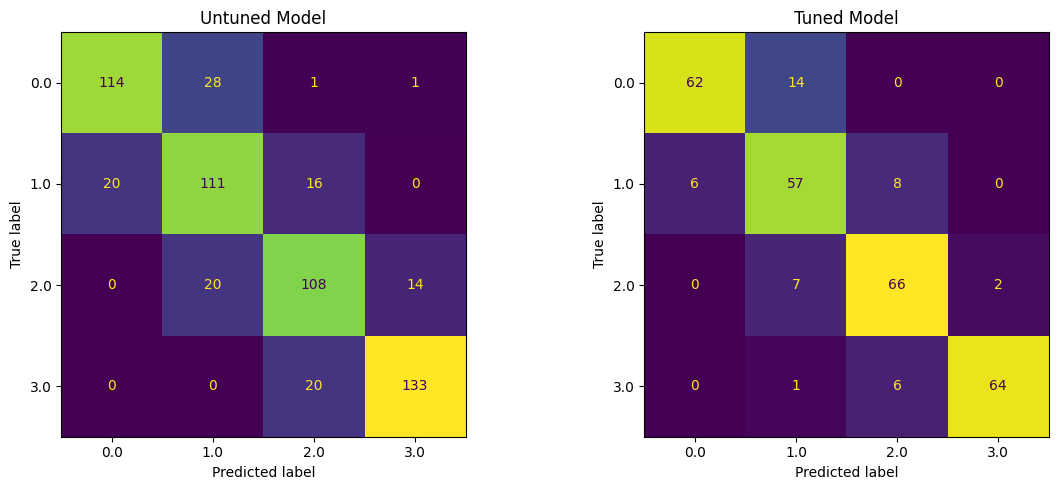

In [312]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

print("Default Model:")
print("  Accuracy:", accuracy_score(Y_test, y_pred_untuned))
print("  F1:", f1_score(Y_test, y_pred_untuned, average='weighted'))
print(f"  Recall Score: {recall_score(Y_test, y_pred_untuned, average=None)}")
print(f"  Precision Score: {precision_score(Y_test, y_pred_untuned, average=None)}")

print("\nTuned Model:")
print("  Accuracy:", accuracy_score(Y_test2, y_pred2_tuned))
print("  F1:", f1_score(Y_test2, y_pred2_tuned, average='weighted'))
print(f"  Recall Score: {recall_score(Y_test2, y_pred2_tuned, average=None)}")
print(f"  Precision Score: {precision_score(Y_test2, y_pred2_tuned, average=None)}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_untuned, ax=axes[0], colorbar=False)
axes[0].set_title("Untuned Model")

ConfusionMatrixDisplay.from_predictions(Y_test2, y_pred2_tuned, ax=axes[1], colorbar=False)
axes[1].set_title("Tuned Model")

plt.tight_layout()
plt.show()

In [383]:
import lightgbm as lgbm
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


params = {
    "objective": "multiclass",
    "num_class": 4,
    "learning_rate": 0.1,
    "metric": "multi_logloss"
}

train_data = lgbm.Dataset(X_train, label=Y_train)
test_data = lgbm.Dataset(X_test, label=Y_test, reference=train_data)

num_round = 100
light_model = lgbm.train(params, train_data, num_round, valid_sets=[test_data])

y_pred3 = light_model.predict(X_test)
y_pred3 = np.argmax(y_pred3, axis=1)
print('\n\n')
print(f"Accuracy: {accuracy_score(Y_test, y_pred3)}")
print(f"F1 Score: {f1_score(Y_test, y_pred3, average=None)}")
print(f"Recall Score: {recall_score(Y_test, y_pred3, average=None)}")
print(f"Precision Score: {precision_score(Y_test, y_pred3, average=None)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.371027
[LightGBM] [Info] Start training from score -1.394878
[LightGBM] [Info] Start training from score -1.379480
[LightGBM] [Info] Start training from score -1.400064



Accuracy: 0.7901023890784983
F1 Score: [0.82142857 0.70469799 0.74324324 0.89261745]
Recall Score: [0.79861111 0.71428571 0.77464789 0.86928105]
Precision Score: [0.84558824 0.69536424 0.71428571 0.91724138]


In [384]:
import lightgbm as lgbm
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


params = {
    "objective": "multiclass",
    "num_class": 4,
    "learning_rate": 0.3,
    "metric": "multi_logloss"
}

train_data = lgbm.Dataset(X_train, label=Y_train)
test_data = lgbm.Dataset(X_test, label=Y_test, reference=train_data)

num_round = 100
light_model = lgbm.train(params, train_data, num_round, valid_sets=[test_data])

y_pred4 = light_model.predict(X_test)
y_pred4 = np.argmax(y_pred4, axis=1)
print('\n\n')
print(f"Accuracy: {accuracy_score(Y_test, y_pred4)}")
print(f"F1 Score: {f1_score(Y_test, y_pred4, average=None)}")
print(f"Recall Score: {recall_score(Y_test, y_pred4, average=None)}")
print(f"Precision Score: {precision_score(Y_test, y_pred4, average=None)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.371027
[LightGBM] [Info] Start training from score -1.394878
[LightGBM] [Info] Start training from score -1.379480
[LightGBM] [Info] Start training from score -1.400064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [393]:
# Scatter plot comparing the two models
sns.scatterplot(data=localCopy, x=y_pred_untuned, y=y_pred_tuned, hue='True', palette='viridis', alpha=0.6)



plt.figure(figsize=(3,2))
plt.scatter(Y_test, y_pred_untuned, alpha=0.5, label='Untuned XGB model', s=20,color='red')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Untuned XGBoost model")
plt.show()


plt.figure(figsize=(3,2))
plt.scatter(Y_test2, y_pred2_tuned, alpha=0.5, label='Tuned XGB model', s=20,color='red')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Tuned XGBoost model")
plt.show()


plt.figure(figsize=(3,2))
plt.scatter(Y_test, y_pred3, alpha=0.5, label="Untuned LightGBM model", s=20,color='blue')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Untuned LightGBM model")
plt.show()

plt.figure(figsize=(3,2))
plt.scatter(Y_test2, y_pred4, alpha=0.5, label="Tuned LightGBM model", s=20,color='blue')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Tuned LightGBM model")
plt.show()


ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 2926 and the vector passed to `x` has length 586.